In [1]:
# ! pip install dataframe-image
import dataframe_image as dfi

# ! pip install pydub
import pydub

# ! pip install playsound pygobject
from playsound import playsound

import pandas as pd
import numpy as np
import torch
from torch import nn
from pathlib import Path
from matplotlib import pyplot as plt

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


----
# Decoding Morse code

* **Binary language for humans**
* **Telegraph**
* **HAM radio**
* **Sailors banging on the hull of submarines**

In [2]:
IMAGES_DIR = Path.home() / 'code' / 'tangibleai' / 'nlpia-manuscript' 
IMAGES_DIR /= Path('manuscript') / 'images' / 'ch07'
HOME_DATA_DIR = Path.home() / '.nlpia2-data'

def savefig(ax, filename, images_dir=IMAGES_DIR, **kwargs):
    if not Path(filename).is_file():
        filepath = Path(images_dir) / filename
    if isinstance(ax, (list, tuple)):
        ax = ax[0]
    if hasattr(ax, 'figure'):
        return ax.figure.savefig(filepath, **kwargs)
    if hasattr(ax, 'savefig'):
        return ax.savefig(filepath, **kwargs)
    return plt.savefig(filepath)

----

## Morse code audio

In [27]:
from nlpia2.init import maybe_download
from playsound import playsound

url = 'https://upload.wikimedia.org/wikipedia/' \
      'commons/7/78/1210secretmorzecode.wav'
filepath = maybe_download(url)
playsound(filepath, block=False)

In [28]:
! kill -9 $(ps aux | grep playsound | cut -c12-16)

----
## Audio as data

In [5]:
from pathlib import Path
from scipy.io import wavfile

# filepath = HOME_DATA_DIR / '1210secretmorzecode.wav'
sample_rate, audio = wavfile.read(filepath)
print(f'sample_rate: {sample_rate}')
print(f'audio:\n{audio}')

sample_rate: 4000
audio:
[255   0 255 ...   0 255   0]


In [6]:
print(audio.shape, audio.dtype)

(962304,) uint8


----
## Data cleaning

We only care about the amplitude of the beeps

In [7]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 7

audio = audio[:sample_rate * 2]                 # <1>
audio = np.abs(audio - audio.max() / 2) - .5    # <2>
audio = audio / audio.max()                     # <3>
audio = audio[::10]                             # <4>
sample_rate /= 10
audio = pd.Series(audio, name='audio')
audio.index = 1000 * audio.index / sample_rate  # <5>
audio.index.name = 'Time (ms)'

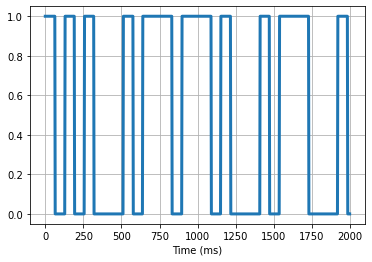

In [8]:
ax = audio.plot(linewidth=3, grid='on')

----
## Dot-detecting kernel (pattern)

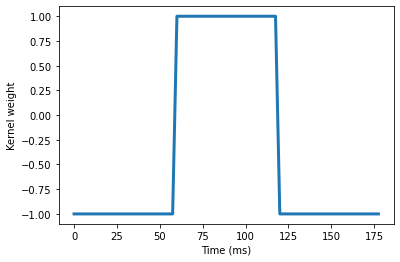

In [10]:
dot_kernel = [-1] * 24 + [1] * 24 + [-1] * 24                      # <1>
dot_kernel = pd.Series(dot_kernel, index=2.5 * np.arange(len(dot_kernel)))
dot_kernel.index.name = 'Time (ms)'
ax = dot_kernel.plot(linewidth=3, ylabel='Kernel weight')

----
## Dash-detecting kernel (pattern)

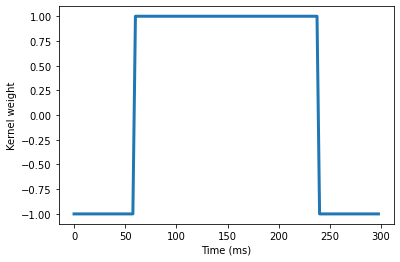

In [13]:
dash_kernel = [-1] * 24 + [1] * 24 * 3 + [-1] * 24                      # <1>
dash_kernel = pd.Series(dash_kernel, index=2.5 * np.arange(len(dash_kernel)))
dash_kernel.index.name = 'Time (ms)'
ax = dash_kernel.plot(linewidth=3, ylabel='Kernel weight')

----
## Convolution

In [14]:
def convolve(inpt, kernel, aggregator=sum):
    output = []
    for i in range(len(inpt) - len(kernel) + 1):  # <1>
        output.append(
            aggregator(
                [
                    inpt[i + k] * kernel[k]
                    for k in range(len(kernel))  # <2>
                ]
            )
        )
    return output

----
## Dot-detecting kernel (pattern)

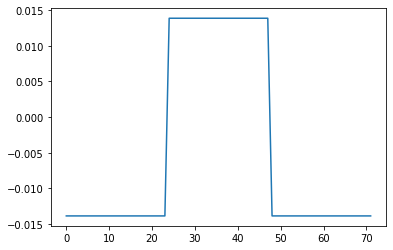

In [15]:
dot_kernel = np.array(dot_kernel) / sum(np.abs(dot_kernel))  # <1>
plt.plot(dot_kernel)

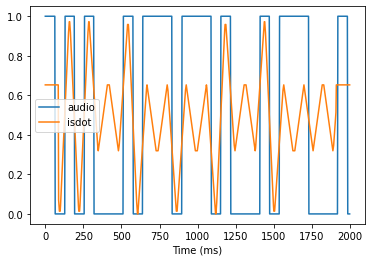

In [16]:
pad = [0] * (len(dot_kernel) // 2)                   # <2>
isdot = convolve(audio.values, dot_kernel, aggregator=sum)
isdot =  np.array(pad[:-1] + list(isdot) + pad)  # <3>

df = pd.DataFrame()
df['audio'] = audio
df['isdot'] = isdot - isdot.min()
ax = df.plot()

----
## Dash-detecting kernel (pattern)

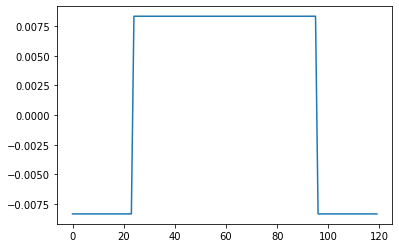

In [17]:
dash_kernel = np.array(dash_kernel) / sum(np.abs(dash_kernel))  # <1>
plt.plot(dash_kernel)

----
## audio -> dots and dashes

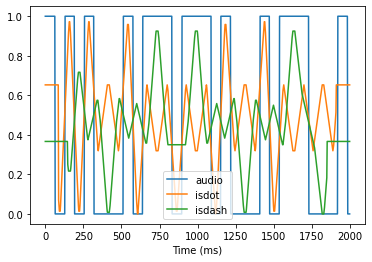

In [18]:
pad = [0] * (len(dash_kernel) // 2)               
isdash = convolve(audio.values, dash_kernel, aggregator=sum)
isdash =  np.array(pad[:-1] + list(isdash) + pad)  

df['isdash'] = isdash - isdash.min()
ax = df.plot()

----
## Morse code for "S"

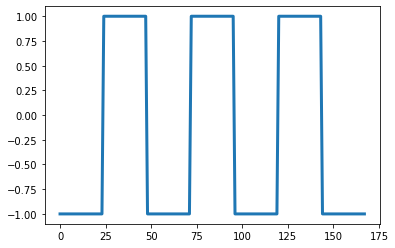

In [25]:
s_kernel = (([-1] * 24 + [1] * 24) * 3 + [-1] * 24) / sum(np.abs(dash_kernel))
plt.plot(s_kernel, linewidth=3)

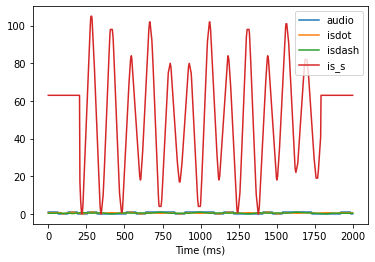

In [26]:
pad = [0] * (len(s_kernel) // 2)               
is_s = convolve(audio.values, s_kernel, aggregator=sum)
is_s =  np.array(pad[:-1] + list(is_s) + pad)  

df['is_s'] = is_s - is_s.min()
ax = df.plot()

In [ ]:
# UNUSED

s_kernel = np.array(s_kernel) / sum(np.abs(s_kernel))
is_s = np.convolve(audio.values, s_kernel, mode='same') 
df['is_s'] = is_s - is_s.min()
ax = df.plot()


In [ ]:
savefig(ax, 's-kernel-convolved-with-secret-message.png')

In [ ]:
# .Learnable embedding layer

from torch import nn

embedding = nn.Embedding(
    num_embeddings=3000,  # <1>
    embedding_dim=50,     # <2>
    padding_idx=0)

# <1> you must use the same size here as you use in your tokenizer
# <2> the smallest useful GloVE embeddings have 50 dimensions

In [ ]:
embedding

In [ ]:
# Listing 7.TBD12
# .Load news posts

df = pd.read_csv(HOME_DATA_DIR / 'news.csv')
df = df[['text', 'target']]  # <1>
print(df)

# <1> you only need the text and binary newsworthiness label for your CNN training

In [ ]:
# // Listing 7.TBD13
# .Most common words for your vocabulary

import re
from collections import Counter
from itertools import chain

counts = Counter(chain(*[
    re.findall(r'\w+', t.lower()) for t in df['text']]))     # <1>
vocab = [tok for tok, count in counts.most_common(4000)[3:]] # <2>
vocab += ['sacred']

print(counts.most_common(6))

# <1> tokenizing, case folding, and occurrence counting
# <2> ignore the 3 most frequent tokens ("t", "co", "http")


In [ ]:
# // Listing 7.TBD14 
# .Multipurpose padding function

def pad(sequence, pad_value, seq_len):
    padded = list(sequence)[:seq_len]
    padded = padded + [pad_value] * (seq_len - len(padded))
    return padded

In [ ]:
# .Load embeddings and align with your vocabulary

from nessvec.files import load_vecs_df

glove = load_vecs_df(HOME_DATA_DIR / 'glove.6B.50d.txt')
vocab = [tok for tok in vocab if tok in glove.index]         # <1>
embed = glove.loc[vocab]                                     # <2>

print(f'embed.shape: {embed.shape}')
print(f'vocab:\n{pd.Series(vocab)}')

# <1> skip unknown embeddings; alternatively create zero vectors
# <2> ensure your embedding matrix is in the same order as your vocab

In [ ]:
# Figure 7.TBD
# cnn-embeddings-glove-words-are-sacred.drawio.png

words = embed.loc[['words', 'are', 'sacred']].T
words['.'] = 0.0
words['<pad>'] = 0.0
roundwords = words.round(2)
roundwords

In [ ]:
class CNNTextClassifier(nn.Module):

    def __init__(self, vocab_size=5, embedding_size=50):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=5,
            embedding_dim=50,
            padding_idx=0)
        self.conv = nn.Conv1d(
            in_channels=50,
            out_channels=50,
            groups=50,
            kernel_size=2,
            stride=1)
    
    def forward(self, x):
        
        embeddings = self.embedding(x)
        print(f"embeddings.size(): {embeddings.size()}")
        print(f"embeddings:\n{embeddings}")
        features = self.conv(embeddings)
        print(f"features.size(): {features.size()}")
        print(f"features:\n{features}")
        return features.squeeze()


In [ ]:
import torch
cnn = CNNTextClassifier()
index_seq = torch.tensor([[1, 2, 3, 4] + [0] * 46 ])
torch.range(5)
print(f"index_seq.dtype: {index_seq.dtype}")
print(f"index_seq.size(): {index_seq.size()}")
cnn.forward(index_seq)

In [ ]:
filepath = Path('df-glove-vectors-sacred-pad-1.png')
if filepath.is_file():
    filepath.unlink()
dfi.export(roundwords, filepath, max_rows=7)

![df-glove-vectors-sacred-pad.png](df-glove-vectors-sacred-pad.png)

In [ ]:
# .Initialize your embedding layer with GloVE vectors

import torch
embed = torch.Tensor(embed.values)                         # <1>
print(f'embed.size(): {embed.size()}')
embed = nn.Embedding.from_pretrained(embed, freeze=False)  # <2>
print(embed)

# <1> convert Pandas DataFrame to a torch.Tensor
# <2> freeze=False allows your Embedding layer to fine-tune your embeddings

In [ ]:
# .Initialize your CNN hyperparameters

class CNNTextClassifier(nn.Module):

    def __init__(self, embeddings=glove):
        super().__init__()

        self.seq_len = 35                         # <1>
        self.vocab_size = embeddings.shape[0]
        self.embedding_size = embeddings.shape[1]
        self.kernel_lengths = [2]                 # <2>
        self.stride = 2
        self.conv_output_size = 50                # <3>

        self.dropout = nn.Dropout(.2)

        self.embedding = nn.Embedding(self.vocab_size + 1, self.embedding_size, padding_idx=0)

        self.convolvers = []
        self.poolers = []
        for i, kernel_len in enumerate(self.kernel_lengths):
            self.convolvers.append(nn.Conv1d(self.seq_len, self.conv_output_size, kernel_len, self.stride))
            self.poolers.append(nn.MaxPool1d(kernel_len, self.stride))

        self.encoding_size = self.cnn_output_size()
        self.linear_layer = nn.Linear(self.encoding_size, 1)

# <1> assume a maximum text length of 35 tokens
# <2> only one kernel layer is needed for reasonable results
# <3> the convolution output need not have the same number of channels as your embeddings


    def cnn_output_size(self):
        """ Calculate the number of encoding dimensions output from CNN layers

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        """
        out_pool_total = 0
        for kernel_len in self.kernel_lengths:
            out_conv = ((self.embedding_size - 1 * (kernel_len - 1) - 1) / self.stride) + 1
            out_conv = math.floor(out_conv)
            out_pool = ((out_conv - 1 * (kernel_len - 1) - 1) / self.stride) + 1
            out_pool = math.floor(out_pool)
            out_pool_total += out_pool

        # Returns "flattened" vector (input for fully connected layer)
        return out_pool_total * self.conv_output_size

In [ ]:
np.array(embed).shape



In [ ]:
import json
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 40
from pathlib import Path

paths = list((Path.home() / '.nlpia2-data' / 'log').glob('*'))
df = []
for p in paths:
    d = json.load(p.open())
    df.append({k:d.get(k) for k in d.keys() if k not in ('learning_curve', 'y_test', 'y_train')})
    df[-1]['filename'] = p.name[-12:-5]
df = pd.DataFrame(df)
df.sort_values('test_accuracy').round(2).tail(10).T

In [ ]:
# FIXME: both implementations look incorrect because pooling should not add additional dimensions/sequence elements to the encoding

# .Compute the shape of the CNN output (the number of the output encoding vector dimensions)


def conv1_output_encoding_size(self, embedding_size, kernel_lengths, stride, output_channels):
    """ Calculate the number of encoding dimensions output from CNN layers

    Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
    Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

    source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    """
    out_pool_total = 0
    for kernel_len in kernel_lengths:
        out_conv = (
            (embedding_size - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_conv = math.floor(out_conv)
        out_pool = ((out_conv - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_pool = math.floor(out_pool)
        out_pool_total += out_pool

    # return the len of a "flattened" vector that is passed into a fully connected (Linear) layer
    return out_pool_total



In [ ]:

def compute_output_seq_len(input_seq_len, kernel_lengths, stride):
    """ Calculate the number of encoding dimensions output from CNN layers

    From PyTorch docs:
      L_out = 1 + (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride
    But padding=0 and dilation=1, because we're only doing a 'valid' convolution.
    So:
      L_out = 1 + (L_in - (kernel_size - 1) - 1) // stride

    source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    """
    out_pool_total = 0
    for kernel_len in kernel_lengths:
        out_conv = (
            (input_seq_len - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_conv = math.floor(out_conv)
        out_pool = ((out_conv - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_pool = math.floor(out_pool)
        out_pool_total += out_pool

    # return the len of a "flattened" vector that is passed into a fully connected (Linear) layer
    return out_pool_total


In [ ]:
import json
import pandas as pd
from pathlib import Path

pd.options.display.max_columns = 100
pd.options.display.max_rows = 40


def best_hyperparms():
    paths = list((Path.home() / '.nlpia2-data' / 'log').glob('*'))
    df = []
    for p in paths:
        d = json.load(p.open())
        df.append({k: d.get(k) for k in d.keys() if k not in ('learning_curve', 'y_test', 'y_train')})
        df[-1]['filename'] = p.name[-12:-5]
    df = pd.DataFrame(df)
    df.sort_values('test_accuracy').round(2).tail(10).T


def learning_curve(filepath=Path.home() / '.nlpia2-data' / 'log' / 'disaster_tweets_cnn_pipeline_14728.json'):
    with Path(filepath).open() as fin:
        results = json.load(fin)

    curve = pd.DataFrame(results['learning_curve'],
                         columns=['loss', 'training_accuracy', 'test_accuracy'])
    return curve

In [ ]:
curve = learning_curve()

accuracy = curve[['training_accuracy', 'test_accuracy']]
accuracy.plot(linewidth=3, xlabel='Epochs', ylabel='Accuracy')

In [ ]:
savefig(ax, IMAGES_DIR / 'learning-curve-85-80.png')